In [1]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai # upgrade fastai on colab

In [2]:
# import torch; torch.cuda.device_count()
# import torch; torch.cuda.get_device_properties(0)

# MIMIC III (sample) Code Prediction

In [3]:
import fastbook
fastbook.setup_book()

from fastbook import *

Application specific imports from fastai:

In [4]:
from fastai.text.all import *
from fastai.distributed import *

xcube specific imports:

In [5]:
from xcube.text.learner import text_classifier_learner
from xcube.metrics import PrecisionK

#### Setting the base path of the repository

In [6]:
path = Path.cwd()
path_data = path/'data'
path_model = path/'models'

path, path_data, path_model

(Path('/home/deb/xcube/nbs/examples/mimic'),
 Path('/home/deb/xcube/nbs/examples/mimic/data'),
 Path('/home/deb/xcube/nbs/examples/mimic/models'))

## `DataLoaders` for the Multi-Label Calssifier

In [7]:
!ls -lh {path_data/"*caml*"}

-rw-r--r-- 1 deb deb 472M Feb  3 19:08 /home/deb/xcube/nbs/examples/mimic/data/caml_notes_labelled.csv
-rw-r--r-- 1 deb deb  48M Feb  4 16:28 /home/deb/xcube/nbs/examples/mimic/data/caml_notes_labelled_sample_10percent.csv


In [8]:
!ls -lh {path_model/"caml*recent*"}

-rw-r--r-- 1 deb deb 1.2G Feb  5 20:41 /home/deb/xcube/nbs/examples/mimic/models/caml_dls_lm_recent.pkl
-rw-r--r-- 1 deb deb 909K Feb  5 20:41 /home/deb/xcube/nbs/examples/mimic/models/caml_dls_lm_vocab_recent.pkl
-rw-r--r-- 1 deb deb 157M Feb  6 02:29 /home/deb/xcube/nbs/examples/mimic/models/caml_lm_finetuned_recent.pth
-rw-r--r-- 1 deb deb 157M Feb  6 00:43 /home/deb/xcube/nbs/examples/mimic/models/caml_lm_recent.pth


In [9]:
data_file = path_data/'caml_notes_labelled_sample_10percent.csv'
lm_vocab_file = path_model/'caml_dls_lm_vocab.pkl'

In [10]:
df = pd.read_csv(data_file, dtype={'text': str, 'labels': str})
df[['text', 'labels']] = df[['text', 'labels']].astype('str')

In [11]:
len(df)

5273

In [16]:
# df.head(3)

---

In [18]:
df['length'] = df.apply(lambda row: len(row.text), axis=1)

In [ ]:
df

In [ ]:
np.percentile(df.length, 50)

In [ ]:
np.mean(df.length)

In [21]:
df['text'] = df.apply(lambda row: row.text[10000:], axis=1)

In [ ]:
df

In [ ]:
print(df.text[678])

---

In [12]:
lm_vocab = torch.load(lm_vocab_file)
L(lm_vocab)

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [13]:
label_freq = Counter()
for labels in df.labels: label_freq.update(labels.split(';'))
lbls = list(label_freq.keys())

In [14]:
L(lbls)

(#4716) ['518.81','348.4','348.82','801.25','427.89','E882','V49.86','305.00','96.71','38.93'...]

In [15]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

In [16]:
train, valid = splitter(df)

In [17]:
L(train), L(valid)

((#4940) [0,1,2,3,4,5,6,7,8,9...],
 (#333) [4940,4941,4942,4943,4944,4945,4946,4947,4948,4949...])

In [18]:
dblock = DataBlock(
        blocks = (TextBlock.from_df('text', seq_len=72, vocab=lm_vocab), MultiCategoryBlock(vocab=lbls)),
        get_x = ColReader('text'),
        get_y = ColReader('labels', label_delim=';'),
        splitter = splitter,
)

In [19]:
dls = dblock.dataloaders(df, bs=32)

In [20]:
torch.save(dls, path_model/'caml_dls_clas_sample_10percent_32.pkl')

---

In [24]:
dls_clas = torch.load(path_model/'caml_dls_clas_sample_10percent_32.pkl')

In [25]:
dls_clas.show_batch(max_n=1)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))


,text,None
0,xxbos admission date discharge date date of birth sex m service medicine allergies penicillins sulfa sulfonamides attending first name3 lf chief complaint lethargy persistent sinus tachycardia major surgical or invasive procedure none history of present illness mr known lastname is a year old male with hiv cd4 one month ago parkinson s disease htn chronic lower extremity edema and recurrent cellulitis who was brought to ed from hospital1 with lethargy and leukocytosis and then admitted to micu with colitis and persistent sinus tachycardia patient is somewhat unreliable historian but reports weeks of diarrhea and abdominal pain that have been worsening he reports coming to the hospital because he continued to ask and express concern about his diarrhea per hospital1 notes has been having loose bowel movements x6 with wbcs of 24k t refusing meals and lethargic of note he was treated with course of ciprofloxacin for uti in in the,427.89;584.9;995.92;785.52;599.0;305.1;V12.04;008.45;296.80;348.39;041.6;042;038.8;332.0;304.01;304.21


In [26]:
coll_repr(dls_clas.vocab[0], 30)

"(#51928) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','and','to','of','was','with','a','on','in','for','mg','no','tablet','patient','is','he','at','blood','name','po','she'...]"

In [27]:
coll_repr(dls_clas.vocab[1], 30)

"(#4716) ['518.81','348.4','348.82','801.25','427.89','E882','V49.86','305.00','96.71','38.93','861.32','958.4','868.14','881.20','289.82','862.1','902.53','860.5','991.6','E922.9','V66.7','32.39','34.02','38.84','54.11','34.82','39.32','34.09','86.28','99.04'...]"

In [28]:
# x, y = dls_clas.one_batch()
# x.shape, y.shape

In [29]:
# x, y = first(dls_clas.train)
dls_iter = iter(dls_clas.train)

In [32]:
x,y = next(dls_iter)

In [33]:
x.shape, y.shape

(torch.Size([32, 3560]), torch.Size([32, 4716]))

In [34]:
coll_repr(lm_vocab, 30)

"(#51928) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','and','to','of','was','with','a','on','in','for','mg','no','tablet','patient','is','he','at','blood','name','po','she'...]"

In [35]:
' '.join(lm_vocab[o] for o in x[0][:1000])

'xxbos admission date discharge date date of birth sex m service medicine allergies sevoflurane location un juice reglan bactrim attending first name3 lf chief complaint fevers chills nausea vomiting inability to take po major surgical or invasive procedure graft excision tunnelled hd catheter placement history of present illness this is a yo m with dm1 c b nephropathy esrd on hd through av graft tts and esophagitis who presents with three days of fevers chills nausea vomiting and inability to tolerate po the patient was in his usoh until saturday when he developed intractable nausea after hd the patient notes a normal hd session only complicated by a small amount of bleeding at the graft site after hd the patient had nausea and vomited some food bilious material and what he says is coffee ground color material the patient did not have any hematemesis he vomited times and was unable to eat or drink the patient denied any other gi symptoms including diarrhea melena or hematochezia he en

## `DataLoaders` for the Multi-Label Classifier (using fastai's Mid-Level Data API):

### Loading Raw Data

In [7]:
data_file = path_data/'caml_notes_labelled_sample_10percent.csv'
lm_vocab_file = path_model/'caml_dls_lm_vocab.pkl'

In [8]:
df = pd.read_csv(data_file, dtype={'text': str, 'labels': str})
df[['text', 'labels']] = df[['text', 'labels']].astype('str')

In [ ]:
df.head(3)

let's now gather the labels from the 'labels' column of the df:

In [9]:
label_freq = Counter()
for labels in df.labels: label_freq.update(labels.split(';'))

The total number of labels are:

In [10]:
len(label_freq)

4716

Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [11]:
lbls = list(label_freq.keys()) 

### Steps for creating the classifier `DataLoaders` using fastai `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [12]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [13]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#4940) [0,1,2,3,4,5,6,7,8,9...],
 (#333) [4940,4941,4942,4943,4944,4945,4946,4947,4948,4949...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [14]:
lm_vocab = torch.load(lm_vocab_file)

In [15]:
L(lm_vocab)

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [16]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]

In [17]:
dsets = Datasets(df, tfms, splits=splits)

Let's now check if our `Datasets` got created alright:

In [18]:
len(dsets.train), len(dsets.valid)

(4940, 333)

In [19]:
dsets.train[0]

(TensorText([    2,    50,    51,    30,    51,    51,    12,   225,   248,   321,   106,   174,   157,    20,    95,   157,  1920,   549,  1934,   301,    60,   271,   227,   324,   309,    32,    62,
           781,   311,   175,    31,   313,   173,   351,    41,    12,   137,   234, 20920,   486,    32,    62,   781,    61,  4261,    25,  2066,   228,  1290,    10,  6786,   896,    16,  4461,
           350,  3732,  4343,    18,  6340,   334,    80,    17,     9,  1361,     9,    22,    13,   228,    11,    48,  3281,    11,     9,    32,    14,   275,    12,   218,    29,    13,    86,
          3262,  1247,    10,    13,    98,    16,  1462,   129,   123,    41,   882,   238,    41,   882,   147,    41,   882,   145,   138,   934,   335,   223,    66,   190,   293,  3688,    12,
             9,    39, 10039,  5654,  5811,   604,    18,  1017,  5205,  2213,   226,  1912,    12,     9,    39,  1160,   579,   160,  6685, 10040,  5796,   689,   759,   358,   319,    47,    48,
      

---

In [23]:
type(dsets.train[0][0])

fastai.text.data.TensorText

In [33]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
dsets.train[0][0][:] = TensorText(torch.arange(361))

In [37]:
dsets.train[0][0]

TensorText([    2,    50,    51,    30,    51,    51,    12,   225,   248,   321,   106,   174,   157,    20,    95,   157,  1920,   549,  1934,   301,    60,   271,   227,   324,   309,    32,    62,
          781,   311,   175,    31,   313,   173,   351,    41,    12,   137,   234, 20920,   486,    32,    62,   781,    61,  4261,    25,  2066,   228,  1290,    10,  6786,   896,    16,  4461,
          350,  3732,  4343,    18,  6340,   334,    80,    17,     9,  1361,     9,    22,    13,   228,    11,    48,  3281,    11,     9,    32,    14,   275,    12,   218,    29,    13,    86,
         3262,  1247,    10,    13,    98,    16,  1462,   129,   123,    41,   882,   238,    41,   882,   147,    41,   882,   145,   138,   934,   335,   223,    66,   190,   293,  3688,    12,
            9,    39, 10039,  5654,  5811,   604,    18,  1017,  5205,  2213,   226,  1912,    12,     9,    39,  1160,   579,   160,  6685, 10040,  5796,   689,   759,   358,   319,    47,    48,
         12

---

In [29]:
dsets.decode(dsets.train[0])

('xxbos admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam expired pertinent results ct head new effacement of the left perimesencephalic cistern raises concern for early uncal herniation increased density of the left subdural hematoma likely reflects organization redistribution although active bleeding can not be excluded unchanged mm axial dimension of the subdural hematoma with unchanged mm of subfalcine herniation ct head prelim left subdural measur

Looks fine!

#### 3. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size:

In [30]:
bs, sl = 32, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [31]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [32]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                        dl_type=dl_type,
                       before_batch=pad_input_chunk)

Creating the `DataLoaders` object takes considerable amount of time, so let's save it:

In [33]:
torch.save(dls_clas, path_model/'caml_dls_clas_sample_10percent_32.pkl')

Let's take a look at the data:

In [34]:
dls_clas.show_batch(max_n=3)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,xxbos admission date discharge date date of birth sex m service medicine allergies penicillins sulfa sulfonamides attending first name3 lf chief complaint lethargy persistent sinus tachycardia major surgical or invasive procedure none history of present illness mr known lastname is a year old male with hiv cd4 one month ago parkinson s disease htn chronic lower extremity edema and recurrent cellulitis who was brought to ed from hospital1 with lethargy and leukocytosis and then admitted to micu with colitis and persistent sinus tachycardia patient is somewhat unreliable historian but reports weeks of diarrhea and abdominal pain that have been worsening he reports coming to the hospital because he continued to ask and express concern about his diarrhea per hospital1 notes has been having loose bowel movements x6 with wbcs of 24k t refusing meals and lethargic of note he was treated with course of ciprofloxacin for uti in in the,427.89;584.9;995.92;785.52;599.0;305.1;V12.04;008.45;296.80;348.39;041.6;042;038.8;332.0;304.01;304.21
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,V49.86;38.93;276.8;401.9;486;414.01;714.0;428.0;428.32;493.22;491.21;424.0;348.30;410.71;345.3;294.8
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,96.6;401.9;511.9;263.9;496;412;V45.82;441.01;39.73;99.15;434.11;305.1;780.60;43.11;707.03;997.02;E878.2;707.07;348.39;338.18;46.0;41.0;707.21;39.29;39.5;39.9;998.2;344.1;V10.87;336.1;E870.0;707.25;435.2


In [24]:
dls_clas = torch.load(path_model/'caml_dls_clas_sample_10percent_32.pkl')

## `Learner` for Multi-Label Classifier Fine-Tuning

In [7]:
dls_clas = torch.load(path_model/'caml_dls_clas_sample_10percent_32.pkl')

In [ ]:
dls_clas.show_batch(max_n=3)

In [8]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.01, max_len=72*40, metrics=PrecisionK).to_fp16()

In [37]:
learn = learn.load_encoder(path_model/'caml_lm_finetuned')

## Fine-Tuning the Classifier 

In [24]:
# lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
# lr_min, lr_steep, lr_valley, lr_slide

In [38]:
learn.fit_one_cycle(1, lr_max=1e-1, moms=(0.8,0.7,0.8), wd=0.001)

epoch,train_loss,valid_loss,PrecisionK,time
0,0.021091,0.019634,0.243443,01:08


In [39]:
learn.freeze_to(-2)

In [40]:
learn.fit_one_cycle(8, lr_max=1e-2, moms=(0.8,0.7,0.8), wd=0.001, cbs=SaveModelCallback(fname=path_model/'caml_clas_sample_10percent'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.014207,0.018896,0.253654,01:35
1,0.014121,0.018161,0.292292,01:34
2,0.012712,0.017666,0.306707,01:34
3,0.011468,0.017498,0.321321,01:34
4,0.010415,0.017577,0.329329,01:34
5,0.008816,0.017848,0.329129,01:34
6,0.007798,0.017992,0.325526,01:34
7,0.006921,0.018113,0.326927,01:34


Better model found at epoch 0 with valid_loss value: 0.018896428868174553.
Better model found at epoch 1 with valid_loss value: 0.018160950392484665.
Better model found at epoch 2 with valid_loss value: 0.017665915191173553.
Better model found at epoch 3 with valid_loss value: 0.017497621476650238.


In [41]:
learn.freeze_to(-3)

In [42]:
learn.fit_one_cycle(10, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.001, cbs=SaveModelCallback(fname=path_model/'caml_clas_sample_10percent'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.010001,0.017394,0.326126,02:10
1,0.009600,0.017341,0.331532,02:10
2,0.009122,0.017386,0.331932,02:10
3,0.008643,0.017516,0.329329,02:10
4,0.008339,0.017590,0.334935,02:09
5,0.007559,0.017792,0.333333,02:09
6,0.007571,0.017820,0.330531,02:08
7,0.007355,0.017814,0.330531,02:08
8,0.007299,0.017847,0.331532,02:07
9,0.006758,0.017938,0.331131,02:07


Better model found at epoch 0 with valid_loss value: 0.0173944104462862.
Better model found at epoch 1 with valid_loss value: 0.017341431230306625.


In [31]:
learn = learn.load(path_model/'caml_clas_sample_10percent')
learn.validate()

(#2) [0.017542965710163116,0.3147147147147147]

---

In [9]:
learn.unfreeze()

In [10]:
# lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
# lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-4, moms=(0.8,0.7,0.8), wd=0.001)

In [ ]:
learn.fit_one_cycle(50, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.001, cbs=SaveModelCallback(fname=path_model/'caml_clas_sample_10percent'))

In [ ]:
learn.recorder.plot_loss()

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

---

---

In [47]:
learn = learn.load(path_model/'after3_sample')
learn.validate()

(#2) [0.019248120486736298,0.27067067067067063]

In [48]:
learn.unfreeze()

(6.30957365501672e-06,
 6.309573450380412e-07,
 0.00015848931798245758,
 0.0831763744354248)

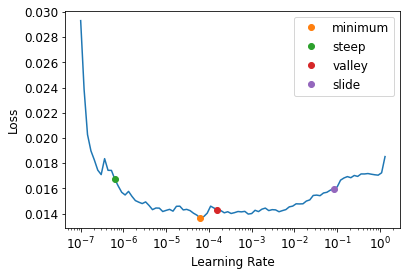

In [49]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [50]:
learn.fit_one_cycle(50, lr_max=0.003, moms=(0.8,0.7,0.8), wd=0.001, cbs=SaveModelCallback(fname=path_model/'clas_sample_10percent_003'))

epoch,train_loss,valid_loss,PrecisionK,time
0,0.014196,0.018997,0.267668,01:02
1,0.013981,0.018796,0.270871,01:02
2,0.013752,0.018583,0.268669,01:01
3,0.013528,0.018265,0.269870,01:02
4,0.013170,0.018100,0.268669,01:02
5,0.012981,0.017986,0.274474,01:02
6,0.013133,0.017639,0.273073,01:02
7,0.013297,0.018014,0.280681,01:01
8,0.013153,0.017882,0.264665,01:02
9,0.012833,0.017861,0.278879,01:02


Better model found at epoch 0 with valid_loss value: 0.018997060135006905.
Better model found at epoch 1 with valid_loss value: 0.018796110525727272.
Better model found at epoch 2 with valid_loss value: 0.018582569435238838.
Better model found at epoch 3 with valid_loss value: 0.018265442922711372.
Better model found at epoch 4 with valid_loss value: 0.018100183457136154.
Better model found at epoch 5 with valid_loss value: 0.017985865473747253.
Better model found at epoch 6 with valid_loss value: 0.01763910800218582.
Better model found at epoch 10 with valid_loss value: 0.017634965479373932.
Better model found at epoch 11 with valid_loss value: 0.01721004582941532.
Better model found at epoch 12 with valid_loss value: 0.01716773211956024.
Better model found at epoch 13 with valid_loss value: 0.017097121104598045.
Better model found at epoch 19 with valid_loss value: 0.017029883340001106.
